## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from fastai_extensions import *

In [3]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [5]:
data_dir = Path('data')
data_04 = Path('data_04')

In [6]:
MODEL_NAME='bg_const'
tfm_name='cutout'

In [7]:
NB_NUM='03_28'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 4f366385, DATE: 20191201


In [9]:
DATE = '20191201'
UID = '0c79e3be'

In [10]:
SUB_NUM='30'

In [11]:
img_size=256
bs=128
background='constant'

In [12]:
train_images=data_04/f'train/rotated/clipped/constant/{img_size}'
test_images=data_04/f'test/rotated/clipped/constant/{img_size}'

In [13]:
train_names = get_image_files(train_images)

In [14]:
test_names = get_image_files(test_images)

In [15]:
def roof_aug_split():
    df_gold = pd.read_csv(data_dir / 'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')
    df_gold.drop(columns=['target'], inplace=True)
    df_gold = df_gold[['id', 'roof_material', 'verified', 'country', 'region']]

    df_pewter_70pct = pd.read_csv(data_dir / 'st_lucia_castries_gros_islet_70pct_rn50-rn152-dn121_preds.csv')
    df_pewter_70pct.tail()
    frames = [df_gold, df_pewter_70pct]
    df_gold_pewter = pd.concat(frames)

    #### test data
    df_test = pd.read_csv(data_dir / 'df_test_all.csv')
    gp_ids = df_gold_pewter.id.values.tolist()

    trn_file_names = []
    for f in train_names:
        trn_file_names.append(f.name.split('.tif')[0])

    bg_const_names = []
    for f in trn_file_names:
        if '_256_bgconstant' in f:
            bg_const_names.append(f.split('_256_bgconstant')[0])

    raw_names = []
    for f in trn_file_names:
        if '_raw' in f:
            raw_names.append(f.split('_raw')[0])

    zoom_names = []
    for f in trn_file_names:
        if '_zoom' in f:
            zoom_names.append(f.split('_zoom')[0])

    reflect_names = []
    for f in trn_file_names:
        if '_256_reflect' in f:
            reflect_names.append(f.split('_256_reflect')[0])

    wrap_names = []
    for f in trn_file_names:
        if '_256_wrap' in f:
            wrap_names.append(f.split('_256_wrap')[0])

    df_gold_pewter_bg_const = df_gold_pewter.loc[df_gold_pewter['id'].isin(bg_const_names)]
    df_gold_pewter_bg_const['id'] = df_gold_pewter_bg_const['id'] + '_256_bgconstant'
    df_gold_pewter_bg_const = df_gold_pewter_bg_const.drop_duplicates(subset=['id'])

    # Ensure is only ids with _256_bgconstant

    #### raw
    df_gold_pewter_raw = df_gold_pewter.loc[df_gold_pewter['id'].isin(raw_names)]
    df_gold_pewter_raw['id'] = df_gold_pewter_raw['id'] + '_raw'
    df_gold_pewter_raw = df_gold_pewter_raw.drop_duplicates(subset=['id'])

    #### zoom
    df_gold_pewter_zoom = df_gold_pewter.loc[df_gold_pewter['id'].isin(zoom_names)]
    df_gold_pewter_zoom['id'] = df_gold_pewter_zoom['id'] + '_zoom'
    df_gold_pewter_zoom = df_gold_pewter_zoom.drop_duplicates(subset=['id'])

    #### wrap
    df_gold_pewter_wrap = df_gold_pewter.loc[df_gold_pewter['id'].isin(wrap_names)]
    df_gold_pewter_wrap['id'] = df_gold_pewter_wrap['id'] + '_256_wrap'
    len(df_gold_pewter_wrap)
    df_gold_pewter_wrap = df_gold_pewter_wrap.drop_duplicates(subset=['id'])

    df_gold_pewter_reflect = df_gold_pewter.loc[df_gold_pewter['id'].isin(reflect_names)]
    df_gold_pewter_reflect['id'] = df_gold_pewter_reflect['id'] + '_256_reflect'
    df_gold_pewter_reflect = df_gold_pewter_reflect.drop_duplicates(subset=['id'])
    return df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw

In [16]:
def get_train_val_test(roof_combinations):
    df_gold_pewter = pd.concat(roof_combinations)

    # ### split df manally
    df_val = df_gold_pewter.sample(frac=0.07)
    df_val_ids = df_val.id.values.tolist()

    core_ds = []
    for id in df_val_ids:
        core_ds.append(id.split('_')[0])

    core_ds = list(set(core_ds))
    df_val = df_gold_pewter[df_gold_pewter['id'].str.contains('|'.join(core_ds))]
    df_train = df_gold_pewter[~df_gold_pewter['id'].str.contains('|'.join(core_ds))]
    df_val['is_valid'] = True
    df_train['is_valid'] = False
    frames = [df_val, df_train]
    df_train = pd.concat(frames)
    return df_train, df_val

In [17]:
def setup_dataset(df_train):
    cutout_1 = cutout(n_holes=(1, 4), length=(10, 20), p=.5)
    cutout_2 = cutout(n_holes=(1, 4), length=(10, 20), p=.5)
    cutout_3 = cutout(n_holes=(1, 4), length=(20, 20), p=.6)
    cutout_4 = cutout(n_holes=(1, 4), length=(20, 20), p=.6)
    xtra_tfms = [cutout_1, cutout_2, cutout_3, cutout_4, rand_crop(p=0.4), rand_zoom(scale=(1., 1.5), p=0.4)]
    tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_warp=0., xtra_tfms=xtra_tfms)

    # ### setup dataset
    np.random.seed(42)
    dep_var = 'roof_material'
    src = (ImageList.from_df(path=train_images, df=df_train, cols='id', suffix='.tif')
           # .split_by_rand_pct(0.1)
           .split_from_df(col='is_valid')
           .label_from_df(cols=dep_var)
           .add_test_folder(test_images))

    data = (src.transform(tfms, size=img_size)
            .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [18]:
df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw = roof_aug_split()
roof_combinations = [df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom]
df_train, df_val=get_train_val_test(roof_combinations)
data=setup_dataset(df_train)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

69849


In [19]:
def index_valid(idxl, learn):
    '''return loss name by order of top loss'''
    lossidx_img={}
    for c, i in enumerate(idxl):
        f=learn.data.valid_ds.items[i]
        lossidx_img[c]=f
    return lossidx_img

def get_img_id(all_images):
    ids=[]
    for img_name in all_images:
        end=img_name.split('/')[-1]
        ids.append(end.split('.tif')[0])
    return ids

In [20]:
def confusion_dump(learn, interp, arch_name, combo_name, run_num):
    all_losses=interp.top_losses(len(interp.losses), largest=True)
    all_idx=all_losses[1].tolist()
    all_loss=all_losses[0].tolist()
    all_images=index_valid(all_idx, learn)
    all_images=list(all_images.values())

    ids=get_img_id(all_images)
    assert len(ids)==len(all_loss)

    # list of strings
    columns=['id','loss']
    df = pd.DataFrame(list(zip(ids, all_loss)),
                   columns =columns)
    mname=f'{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}-{combo_name}-{run_num}'
    print(f'saving {mname}.csv')
    df['model']=mname
    df.to_csv(data_dir/f'processing/model_confusion_qc/{mname}.csv')

In [21]:
def confusion_loss(learn, preds, pred_classes, tl_val, tl_idx, losses, arch_name, combo_name, run_num):
    print('>>confusion_loss()')

    all_images=index_valid(tl_idx, learn)
    all_images=list(all_images.values())
    ids=get_img_id(all_images)
    assert len(ids)==len(losses)

    columns=['id','pred','loss']
    df = pd.DataFrame(list(zip(ids,pred_classes,losses)), columns =columns)
    mname=f'{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}-{combo_name}-{run_num}'
    print(f'saving {mname}.csv')
    df['model']=mname
    df.to_csv(data_dir/f'processing/model_confusion_qc/{mname}.csv')

In [22]:
def get_top_losses(interp, k=20, largest=True):
    tl_val,tl_idx = interp.top_losses(k, largest)
    classes = interp.data.classes
    preds=[]
    pred_classes=[]
    losses=[]
    for i,idx in enumerate(tl_idx):
        im,cl = interp.data.dl(interp.ds_type).dataset[idx]
        cl = int(cl)
        loss=f'{interp.losses[idx]:.2f}'
        pred=f'{interp.preds[idx][cl]:.2f}'
        pred_class=str(classes[interp.pred_class[idx]])
        preds.append(pred)
        pred_classes.append(pred_class)
        losses.append(loss)
    return preds, pred_classes, tl_val, tl_idx, losses

In [23]:

#combo_name='const_ref_wrap_zoom'
combo_name='raw_zoom'
tfm_name='cutout'

In [24]:
arch = models.resnet50
arch_name='rn50'
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [25]:
for run in range(5):
    mname=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}-{combo_name}-{run}'
    learn.load(f'{mname}')
    interp = ClassificationInterpretation.from_learner(learn)
    preds, pred_classes, tl_val, tl_idx, losses=get_top_losses(interp, k=len(interp.losses))
    confusion_loss(learn, preds, pred_classes, tl_val, tl_idx, losses, arch_name, combo_name, run)

>>confusion_loss()
saving rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-4.csv


### load preds to review confusion

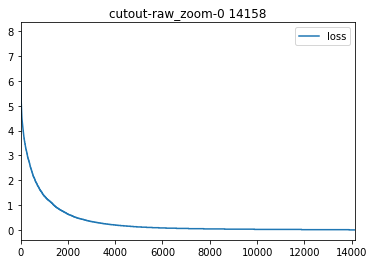

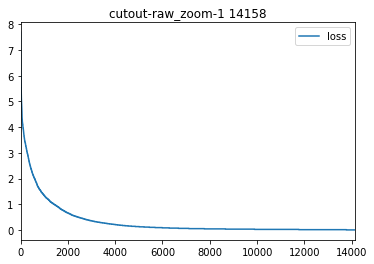

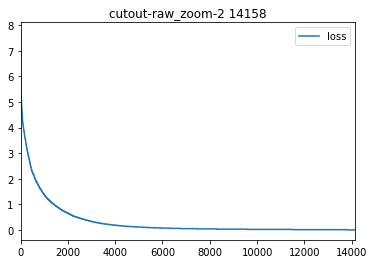

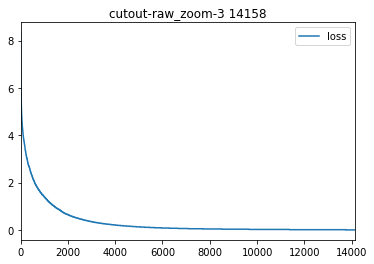

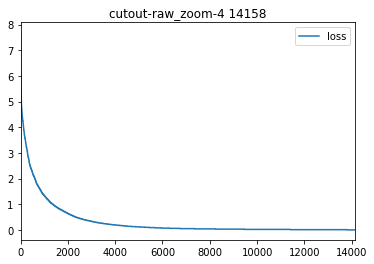

In [81]:
dfs=[]
for run in range(5):
    mname=f'{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}-{combo_name}-{run}'
    df=pd.read_csv(data_dir/f'processing/model_confusion_qc/{mname}.csv')
    df.drop(columns=['Unnamed: 0'],inplace=True)
    df.plot(title=f'{tfm_name}-{combo_name}-{run} {len(df)}')
    dfs.append(df)

In [82]:
df_loss = pd.concat(dfs)

In [83]:
len(df_loss)

70790

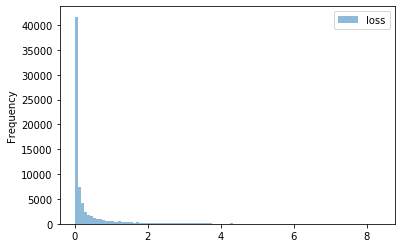

In [84]:
df_loss.plot.hist(alpha=0.5, bins=100)

#### group duplicated ids and force to one pred

In [85]:
dup_df=df_loss[df_loss.duplicated(['id'])]

In [86]:
non_dup_df=df_loss[~df_loss.duplicated(['id'])]

In [87]:
len(non_dup_df)

14158

In [88]:
dup_df.sort_values(by=['id', 'loss'])

,id,pred,loss,model
10783,7a1c5026_256_bgconstant,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-2
10029,7a1c5026_256_bgconstant,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-3
11136,7a1c5026_256_bgconstant,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-4
9024,7a1c5026_256_bgconstant,healthy_metal,0.03,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-1
11827,7a1c5026_256_reflect,healthy_metal,0.01,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-4
...,...,...,...,...
9843,7a44d190_256_reflect,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-3
12487,7a44d190_256_wrap,healthy_metal,0.01,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-1
13591,7a44d190_256_wrap,healthy_metal,0.01,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-2
11530,7a44d190_256_wrap,healthy_metal,0.01,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-4


In [89]:
dup_df[['model_name','run']] = dup_df.model.str.rsplit(pat="-", n=1,expand = True)

In [90]:
dup_df.drop(columns=['model'],inplace=True)

In [91]:
dup_df=dup_df.sort_values(by=['id', 'model_name', 'loss'])

In [92]:
mean_df=dup_df.groupby(['id', 'model_name']).mean()

In [93]:
temp_df=dup_df.drop(columns=['run'],inplace=False)

In [94]:
temp_df.head()

,id,pred,loss,model_name
10783,7a1c5026_256_bgconstant,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
10029,7a1c5026_256_bgconstant,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
11136,7a1c5026_256_bgconstant,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
9024,7a1c5026_256_bgconstant,healthy_metal,0.03,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
11827,7a1c5026_256_reflect,healthy_metal,0.01,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom


In [95]:
df = temp_df[['id','model_name','pred','loss']] 

#### get mode of preds

In [96]:
def get_mode_per_column(dataframe, group_cols, col):
    return (dataframe.fillna(-1)  # NaN placeholder to keep group 
            .groupby(group_cols + [col])
            .size()
            .to_frame('count')
            .reset_index()
            .sort_values('count', ascending=False)
            .drop_duplicates(subset=group_cols)
            .drop(columns=['count'])
            .sort_values(group_cols)
            .replace(-1, np.NaN))  # restore NaNs



In [97]:
group_cols = ['id', 'model_name']
non_grp_cols = list(set(df).difference(group_cols))
output_df = get_mode_per_column(df, group_cols, non_grp_cols[0]).set_index(group_cols)
for col in non_grp_cols[1:]:
    output_df[col] = get_mode_per_column(df, group_cols, col)[col].values
    

#temp_df.groupby(['id', 'model_name']).agg(lambda x:x.value_counts().index[0])

In [98]:
output_df.head()

,,loss,pred
id,model_name,,
7a1c5026_256_bgconstant,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom,0.02,healthy_metal
7a1c5026_256_reflect,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom,0.02,healthy_metal
7a1c5026_256_wrap,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom,0.02,healthy_metal
7a1c5a6c_256_bgconstant,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom,0.03,healthy_metal
7a1c5a6c_256_reflect,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom,0.03,healthy_metal


In [99]:
output_df.pred.unique()

array(['healthy_metal', 'irregular_metal', 'concrete_cement', 'incomplete', 'other'], dtype=object)

In [102]:
list(output_df)

['id', 'model_name', 'loss', 'pred']

In [100]:
output_df=output_df.reset_index()

In [112]:
output_df.rename(columns={'model_name': 'model'}, inplace=True)

In [113]:
output_df=output_df[['id', 'pred', 'loss', 'model']]

In [114]:
non_dup_df.head()

,id,pred,loss,model
0,7a2924c2_256_reflect,irregular_metal,7.96,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
1,7a2924c2_256_wrap,irregular_metal,7.57,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
2,7a2924c2_256_bgconstant,irregular_metal,7.55,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
3,7a1d8428_256_reflect,healthy_metal,6.77,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
4,7a35def6_256_wrap,healthy_metal,6.76,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0


In [115]:
mean_df= pd.concat([output_df, non_dup_df])

<pre>
df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw
</pre>

In [116]:
ids=mean_df.id.unique()

In [117]:
unids=[]
for id in ids:
    b=len(id.split('_')[0])
    unids.append(id[b+1:])

In [118]:
tfm_types=list(set(unids))

In [119]:
tfm_types

['256_reflect', 'zoom', '256_wrap', '256_bgconstant']

In [120]:
zoom_preds=mean_df[mean_df['id'].str.contains("zoom")]
bgconstant_preds=mean_df[mean_df['id'].str.contains("bgconstant")]
reflect_preds=mean_df[mean_df['id'].str.contains("reflect")]
wrap_preds=mean_df[mean_df['id'].str.contains("wrap")]

In [121]:
zoom_preds.head()

,id,pred,loss,model
60,7a1cb2be_zoom,healthy_metal,0.10,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
85,7a1ccef2_zoom,healthy_metal,1.48,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
95,7a1cd780_zoom,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
147,7a1cf2e2_zoom,irregular_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
184,7a1d0cbe_zoom,concrete_cement,0.01,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom


In [122]:
df_gold_pewter_zoom.head()

,id,roof_material,verified,country,region
64,7a42454c_zoom,concrete_cement,True,colombia,borde_rural
72,7a407a64_zoom,irregular_metal,True,colombia,borde_rural
73,7a41a984_zoom,irregular_metal,True,colombia,borde_rural
94,7a320e20_zoom,irregular_metal,True,colombia,borde_rural
184,7a34bb84_zoom,irregular_metal,True,colombia,borde_rural


In [132]:
dup_zoom_id=zoom_preds[zoom_preds.duplicated(['id'], keep=False)]

In [133]:
len(dup_zoom_id)

1034

In [134]:
len(dup_zoom_id.id.unique())

517

In [135]:
dup_zoom_id.sort_values(by=['id'])

,id,pred,loss,model
60,7a1cb2be_zoom,healthy_metal,0.10,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
3027,7a1cb2be_zoom,healthy_metal,0.33,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
298,7a1ccef2_zoom,healthy_metal,2.94,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
85,7a1ccef2_zoom,healthy_metal,1.48,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
10169,7a1cd780_zoom,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
...,...,...,...,...
14143,7a44c768_zoom,healthy_metal,0.19,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
14147,7a44c93e_zoom,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom
10859,7a44c93e_zoom,healthy_metal,0.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0
602,7a44c9b6_zoom,incomplete,2.02,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0


#### containd duplicte indices

In [136]:
zoom_preds = zoom_preds.set_index(["id"])
df_gold_pewter_zoom = df_gold_pewter_zoom.set_index(["id"])

In [146]:
zoom_preds['id'] = zoom_preds.index
df_gold_pewter_zoom['id'] = df_gold_pewter_zoom.index

#### Add preds to larger dataframe

In [166]:
df = df_gold_pewter_zoom.copy()

In [167]:
df['pred']='none'
df['model']='none'
df['loss']=-999.25
df['result']=False

In [168]:
df.head()

,roof_material,verified,country,region,id,pred,model,loss,result
id,,,,,,,,,
7a42454c_zoom,concrete_cement,True,colombia,borde_rural,7a42454c_zoom,none,none,-999.25,False
7a407a64_zoom,irregular_metal,True,colombia,borde_rural,7a407a64_zoom,none,none,-999.25,False
7a41a984_zoom,irregular_metal,True,colombia,borde_rural,7a41a984_zoom,none,none,-999.25,False
7a320e20_zoom,irregular_metal,True,colombia,borde_rural,7a320e20_zoom,none,none,-999.25,False
7a34bb84_zoom,irregular_metal,True,colombia,borde_rural,7a34bb84_zoom,none,none,-999.25,False


In [169]:
df.pred.unique()

array(['none'], dtype=object)

In [170]:
for row in zoom_preds.itertuples():
    id=getattr(row, "id")
    pred=getattr(row, "pred")
    loss=getattr(row, "loss")
    model=getattr(row, "model")
    df.at[id, 'loss'] = loss
    df.at[id, 'pred'] = str(pred)
    df.at[id, 'model'] = str(model)

In [171]:
df.head()

,roof_material,verified,country,region,id,pred,model,loss,result
id,,,,,,,,,
7a42454c_zoom,concrete_cement,True,colombia,borde_rural,7a42454c_zoom,none,none,-999.25,False
7a407a64_zoom,irregular_metal,True,colombia,borde_rural,7a407a64_zoom,none,none,-999.25,False
7a41a984_zoom,irregular_metal,True,colombia,borde_rural,7a41a984_zoom,none,none,-999.25,False
7a320e20_zoom,irregular_metal,True,colombia,borde_rural,7a320e20_zoom,none,none,-999.25,False
7a34bb84_zoom,irregular_metal,True,colombia,borde_rural,7a34bb84_zoom,none,none,-999.25,False


In [172]:
df['result']=df['pred'].equals(df['roof_material'])

In [173]:
df_incorrect=df.loc[(df['pred'] != 'none') & df['result']==False]

In [174]:
len(df_incorrect)

2232

In [175]:
df_incorrect=df_incorrect.sort_values(by='loss', ascending=0)

In [176]:
df_incorrect.head()

,roof_material,verified,country,region,id,pred,model,loss,result
id,,,,,,,,,
7a440ea4_zoom,concrete_cement,False,st_lucia,gros_islet,7a440ea4_zoom,healthy_metal,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0,5.31,False
7a3c0740_zoom,other,True,guatemala,mixco_1_and_ebenezer,7a3c0740_zoom,irregular_metal,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0,4.58,False
7a37eee4_zoom,incomplete,True,colombia,borde_soacha,7a37eee4_zoom,healthy_metal,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0,4.07,False
7a2071e2_zoom,other,True,guatemala,mixco_1_and_ebenezer,7a2071e2_zoom,irregular_metal,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0,3.95,False
7a3cecaa_zoom,concrete_cement,True,guatemala,mixco_1_and_ebenezer,7a3cecaa_zoom,irregular_metal,rn50-03_28-bg_const-cutout-20191201-0c79e3be-raw_zoom-0,3.81,False
